# Merging Census and Health Data
Health data is saved as "health.csv" so change that if you have it labeled as something else.

To change variables extracted in census data, change codes under the "variables of interest section" and update the change name section.

To change variables extracted in census data, change "columns to keep" section.

In [3]:
import pandas as pd
import censusdata

## Census Data

In [4]:
# --- Variables of interest ---
variables = [
    'B19013_001E',  # Median income
    'B01002_001E',  # Median age
    'B17001_002E',  # Poverty
    'B17001_001E',  # Poverty population
    'B15003_017E',  # HS grad
    'B15003_022E',  # Bachelor's degree
    'B15003_001E',  # Education population
    'B23025_005E',  # Unemployed
    'B23025_001E'   # Unemployed population
]

# --- Valid state FIPS codes (50 states + DC) ---
valid_states = [
    '01','02','04','05','06','08','09','10','11','12','13','15','16','17','18','19',
    '20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35',
    '36','37','38','39','40','41','42','44','45','46','47','48','49','50','51','53',
    '54','55','56'
]

# --- Function to parse censusgeo objects ---
def split_geo(cgeo):
    codes = dict(cgeo.geo)
    name_parts = cgeo.name.split(", ")
    tract_name = name_parts[0]
    county_name = name_parts[1]
    state_name = name_parts[2]
    return pd.Series([
        codes.get('state'), codes.get('county'), codes.get('tract'),
        state_name, county_name, tract_name
    ])

# --- Download and process data for all states ---
all_data = []

for state in valid_states:
    print(f"Downloading data for state FIPS: {state}")
    data = censusdata.download(
        'acs5', 2015,
        censusdata.censusgeo([('state', state), ('county', '*'), ('tract', '*')]),
        variables
    )

    # Extract geo info
    geo_cols = data.index.to_series().apply(split_geo)
    geo_cols.columns = [
        'State_FIPS', 'County_FIPS', 'Tract_FIPS',
        'State_Name', 'County_Name', 'Tract_Name'
    ]

    # Combine geo info with data
    data_clean = pd.concat([geo_cols, data], axis=1).reset_index(drop=True)
    all_data.append(data_clean)

# --- Combine all states ---
census_df = pd.concat(all_data, ignore_index=True)

# --- Create 11-digit tract FIPS ---
census_df["Tract_FIPS_full"] = (
    census_df["State_FIPS"].astype(str).str.zfill(2) +
    census_df["County_FIPS"].astype(str).str.zfill(3) +
    census_df["Tract_FIPS"].astype(str).str.zfill(6)
)

#rename variables
census_df.rename(columns={
    'B19013_001E': 'Median_Income',
    'B01002_001E': 'Median_Age',
    'B17001_002E': 'Poverty_Count',
    'B17001_001E': 'Poverty_Pop',
    'B15003_017E': 'HS_Grad_Count',
    'B15003_022E': 'Bachelors_Count',
    'B15003_001E': 'Education_Pop',
    'B23025_005E': 'Unemployed_Count',
    'B23025_001E': 'Unemployed_Pop'
}, inplace=True)


print("ACS tract-level data ready with full 11-digit FIPS!")


ACS tract-level data ready with full 11-digit FIPS!


In [5]:
census_df.head()

,State_FIPS,County_FIPS,Tract_FIPS,State_Name,County_Name,Tract_Name,Median_Income,Median_Age,Poverty_Count,Poverty_Pop,HS_Grad_Count,Bachelors_Count,Education_Pop,Unemployed_Count,Unemployed_Pop,Tract_FIPS_full
0,01,103,005109,Alabama,Morgan County,Census Tract 51.09,29644.0,29.6,1476,4792,695,290,2710,303,3424,01103005109
1,01,103,005106,Alabama,Morgan County,Census Tract 51.06,35864.0,43.3,1186,5723,899,924,4064,293,4796,01103005106
2,01,103,005107,Alabama,Morgan County,Census Tract 51.07,66739.0,43.5,137,4853,632,805,3382,126,4032,01103005107
3,01,103,005108,Alabama,Morgan County,Census Tract 51.08,64632.0,45.8,566,3787,589,535,2769,166,3110,01103005108
4,01,103,005701,Alabama,Morgan County,Census Tract 57.01,46306.0,38.4,571,2784,295,205,1783,52,2022,01103005701


In [6]:
census_df.columns

Index(['State_FIPS', 'County_FIPS', 'Tract_FIPS', 'State_Name', 'County_Name',
       'Tract_Name', 'Median_Income', 'Median_Age', 'Poverty_Count',
       'Poverty_Pop', 'HS_Grad_Count', 'Bachelors_Count', 'Education_Pop',
       'Unemployed_Count', 'Unemployed_Pop', 'Tract_FIPS_full'],
      dtype='object')

## Health Data

In [10]:
from google.colab import files

uploaded = files.upload()  # opens a file picker - make sure you names you file health.csv


health_df = pd.read_csv("health.csv")


Saving health.csv to health (1).csv


In [11]:
health_df.head()

,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Population2010,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,...,PAPTEST_Crude95CI,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation
0,CA,Los Angeles,644000,6037206032,0644000-06037206032,5275,28.0,"(22.7, 33.2)",19.9,"(18.8, 20.9)",...,"(81.5, 86.0)",17.3,"(15.3, 19.2)",38.9,"(37.2, 40.4)",4.0,"( 3.5, 4.5)",18.8,"(12.6, 25.6)",POINT (-118.224698433 34.0470512474)
1,CA,Pasadena,656000,6037462001,0656000-06037462001,3974,23.3,"(19.2, 27.8)",16.7,"(16.0, 17.5)",...,"(84.1, 87.5)",15.3,"(13.9, 16.8)",40.2,"(38.8, 41.5)",3.2,"( 2.9, 3.5)",18.1,"(13.7, 22.8)",POINT (-118.143832177 34.1633689905)
2,CA,Fullerton,628000,6059011504,0628000-06059011504,5473,11.7,"( 9.6, 14.5)",8.3,"( 7.9, 8.7)",...,"(75.4, 80.9)",8.5,"( 7.7, 9.5)",33.4,"(31.6, 35.1)",1.2,"( 1.1, 1.3)",11.9,"( 8.8, 16.0)",POINT (-117.883112998 33.8820402343)
3,TX,Longview,4843888,48183000401,4843888-48183000401,3371,19.3,"(16.8, 21.9)",21.1,"(20.2, 21.9)",...,"(76.5, 81.9)",11.8,"(10.8, 12.8)",34.9,"(33.4, 36.3)",2.7,"( 2.5, 3.0)",15.1,"(10.8, 20.4)",POINT (-94.7523262965 32.5544549842)
4,WI,Madison,5548000,55025002200,5548000-55025002200,4254,10.5,"( 8.7, 12.6)",23.3,"(21.9, 24.6)",...,"(83.4, 88.0)",11.3,"( 9.8, 12.7)",30.8,"(29.3, 32.2)",2.9,"( 2.5, 3.3)",12.9,"( 7.6, 19.8)",POINT (-89.3623704161 43.1211036947)


In [16]:
#extract the 11-digit tract FIPS after the dash
health_df["Tract_FIPS_full"] = health_df["Place_TractID"].str.split("-").str[-1]

In [ ]:
health_df.head()

,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Population2010,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,...,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation,Tract_FIPS_full
0,CA,Los Angeles,644000,6037206032,0644000-06037206032,5275,28.0,"(22.7, 33.2)",19.9,"(18.8, 20.9)",...,17.3,"(15.3, 19.2)",38.9,"(37.2, 40.4)",4.0,"( 3.5, 4.5)",18.8,"(12.6, 25.6)",POINT (-118.224698433 34.0470512474),06037206032
1,CA,Pasadena,656000,6037462001,0656000-06037462001,3974,23.3,"(19.2, 27.8)",16.7,"(16.0, 17.5)",...,15.3,"(13.9, 16.8)",40.2,"(38.8, 41.5)",3.2,"( 2.9, 3.5)",18.1,"(13.7, 22.8)",POINT (-118.143832177 34.1633689905),06037462001
2,CA,Fullerton,628000,6059011504,0628000-06059011504,5473,11.7,"( 9.6, 14.5)",8.3,"( 7.9, 8.7)",...,8.5,"( 7.7, 9.5)",33.4,"(31.6, 35.1)",1.2,"( 1.1, 1.3)",11.9,"( 8.8, 16.0)",POINT (-117.883112998 33.8820402343),06059011504
3,TX,Longview,4843888,48183000401,4843888-48183000401,3371,19.3,"(16.8, 21.9)",21.1,"(20.2, 21.9)",...,11.8,"(10.8, 12.8)",34.9,"(33.4, 36.3)",2.7,"( 2.5, 3.0)",15.1,"(10.8, 20.4)",POINT (-94.7523262965 32.5544549842),48183000401
4,WI,Madison,5548000,55025002200,5548000-55025002200,4254,10.5,"( 8.7, 12.6)",23.3,"(21.9, 24.6)",...,11.3,"( 9.8, 12.7)",30.8,"(29.3, 32.2)",2.9,"( 2.5, 3.3)",12.9,"( 7.6, 19.8)",POINT (-89.3623704161 43.1211036947),55025002200


In [17]:
health_df.columns

Index(['StateAbbr', 'PlaceName', 'PlaceFIPS', 'TractFIPS', 'Place_TractID',
       'Population2010', 'ACCESS2_CrudePrev', 'ACCESS2_Crude95CI',
       'ARTHRITIS_CrudePrev', 'ARTHRITIS_Crude95CI', 'BINGE_CrudePrev',
       'BINGE_Crude95CI', 'BPHIGH_CrudePrev', 'BPHIGH_Crude95CI',
       'BPMED_CrudePrev', 'BPMED_Crude95CI', 'CANCER_CrudePrev',
       'CANCER_Crude95CI', 'CASTHMA_CrudePrev', 'CASTHMA_Crude95CI',
       'CHD_CrudePrev', 'CHD_Crude95CI', 'CHECKUP_CrudePrev',
       'CHECKUP_Crude95CI', 'CHOLSCREEN_CrudePrev', 'CHOLSCREEN_Crude95CI',
       'COLON_SCREEN_CrudePrev', 'COLON_SCREEN_Crude95CI', 'COPD_CrudePrev',
       'COPD_Crude95CI', 'COREM_CrudePrev', 'COREM_Crude95CI',
       'COREW_CrudePrev', 'COREW_Crude95CI', 'CSMOKING_CrudePrev',
       'CSMOKING_Crude95CI', 'DENTAL_CrudePrev', 'DENTAL_Crude95CI',
       'DIABETES_CrudePrev', 'DIABETES_Crude95CI', 'HIGHCHOL_CrudePrev',
       'HIGHCHOL_Crude95CI', 'KIDNEY_CrudePrev', 'KIDNEY_Crude95CI',
       'LPA_CrudePrev', 'LPA_

In [18]:
#filter for columns we want
columns_to_keep = [
    "StateAbbr",
    "PlaceName",
    "PlaceFIPS",
    "TractFIPS",
    "Place_TractID",
    "Tract_FIPS_full",
    "Population2010",
    "OBESITY_CrudePrev",
    "DIABETES_CrudePrev",
    "HIGHCHOL_CrudePrev",
    "BPHIGH_CrudePrev",
    "STROKE_CrudePrev",
    "SLEEP_CrudePrev",
    "MHLTH_CrudePrev",
    "CASTHMA_CrudePrev",
    "CHD_CrudePrev",
    "CSMOKING_CrudePrev"
]

# Filter merged dataframe
health_filtered = health_df[columns_to_keep]

## Merge

In [19]:
merged_df = health_filtered.merge(census_df, on="Tract_FIPS_full", how="inner")

In [20]:
merged_df.columns

Index(['StateAbbr', 'PlaceName', 'PlaceFIPS', 'TractFIPS', 'Place_TractID',
       'Tract_FIPS_full', 'Population2010', 'OBESITY_CrudePrev',
       'DIABETES_CrudePrev', 'HIGHCHOL_CrudePrev', 'BPHIGH_CrudePrev',
       'STROKE_CrudePrev', 'SLEEP_CrudePrev', 'MHLTH_CrudePrev',
       'CASTHMA_CrudePrev', 'CHD_CrudePrev', 'CSMOKING_CrudePrev',
       'State_FIPS', 'County_FIPS', 'Tract_FIPS', 'State_Name', 'County_Name',
       'Tract_Name', 'Median_Income', 'Median_Age', 'Poverty_Count',
       'Poverty_Pop', 'HS_Grad_Count', 'Bachelors_Count', 'Education_Pop',
       'Unemployed_Count', 'Unemployed_Pop'],
      dtype='object')

In [21]:
merged_df.head()

,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Tract_FIPS_full,Population2010,OBESITY_CrudePrev,DIABETES_CrudePrev,HIGHCHOL_CrudePrev,...,Tract_Name,Median_Income,Median_Age,Poverty_Count,Poverty_Pop,HS_Grad_Count,Bachelors_Count,Education_Pop,Unemployed_Count,Unemployed_Pop
0,CA,Los Angeles,644000,6037206032,0644000-06037206032,06037206032,5275,29.5,15.5,38.3,...,Census Tract 2060.32,26094.0,29.5,1829,5104,675,309,2920,185,3835
1,CA,Pasadena,656000,6037462001,0656000-06037462001,06037462001,3974,32.0,11.6,31.8,...,Census Tract 4620.01,40192.0,29.4,947,3893,475,367,2419,167,2903
2,CA,Fullerton,628000,6059011504,0628000-06059011504,06059011504,5473,18.7,4.6,21.1,...,Census Tract 115.04,31793.0,22.8,1740,4768,225,873,2481,379,5547
3,TX,Longview,4843888,48183000401,4843888-48183000401,48183000401,3371,33.9,9.2,33.9,...,Census Tract 4.01,52846.0,34.0,454,3170,637,201,2261,123,2678
4,WI,Madison,5548000,55025002200,5548000-55025002200,55025002200,4254,29.5,8.7,34.6,...,Census Tract 22,42621.0,42.1,491,4026,523,594,2902,339,3429


In [22]:
merged_df.shape

(27209, 32)

## Cleaning

In [23]:
#rename Crude Columns
merged_df = merged_df.rename(columns={
    "Population2010" : "Health_Pop",
    "OBESITY_CrudePrev": "Obesity_Pct",
    "DIABETES_CrudePrev": "Diabetes_Pct",
    "HIGHCHOL_CrudePrev": "HighChol_Pct",
    "BPHIGH_CrudePrev": "HighBP_Pct",
    "STROKE_CrudePrev": "Stroke_Pct",
    "SLEEP_CrudePrev": "Sleep_Pct",
    "MHLTH_CrudePrev": "MentalHealth_Pct",
    "CASTHMA_CrudePrev": "Asthma_Pct",
    "CHD_CrudePrev": "HeartDisease_Pct",
    "CSMOKING_CrudePrev": "Smoking_Pct"
})

In [24]:
merged_df.head()

,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Tract_FIPS_full,Health_Pop,Obesity_Pct,Diabetes_Pct,HighChol_Pct,...,Tract_Name,Median_Income,Median_Age,Poverty_Count,Poverty_Pop,HS_Grad_Count,Bachelors_Count,Education_Pop,Unemployed_Count,Unemployed_Pop
0,CA,Los Angeles,644000,6037206032,0644000-06037206032,06037206032,5275,29.5,15.5,38.3,...,Census Tract 2060.32,26094.0,29.5,1829,5104,675,309,2920,185,3835
1,CA,Pasadena,656000,6037462001,0656000-06037462001,06037462001,3974,32.0,11.6,31.8,...,Census Tract 4620.01,40192.0,29.4,947,3893,475,367,2419,167,2903
2,CA,Fullerton,628000,6059011504,0628000-06059011504,06059011504,5473,18.7,4.6,21.1,...,Census Tract 115.04,31793.0,22.8,1740,4768,225,873,2481,379,5547
3,TX,Longview,4843888,48183000401,4843888-48183000401,48183000401,3371,33.9,9.2,33.9,...,Census Tract 4.01,52846.0,34.0,454,3170,637,201,2261,123,2678
4,WI,Madison,5548000,55025002200,5548000-55025002200,55025002200,4254,29.5,8.7,34.6,...,Census Tract 22,42621.0,42.1,491,4026,523,594,2902,339,3429


In [25]:
merged_df.columns

Index(['StateAbbr', 'PlaceName', 'PlaceFIPS', 'TractFIPS', 'Place_TractID',
       'Tract_FIPS_full', 'Health_Pop', 'Obesity_Pct', 'Diabetes_Pct',
       'HighChol_Pct', 'HighBP_Pct', 'Stroke_Pct', 'Sleep_Pct',
       'MentalHealth_Pct', 'Asthma_Pct', 'HeartDisease_Pct', 'Smoking_Pct',
       'State_FIPS', 'County_FIPS', 'Tract_FIPS', 'State_Name', 'County_Name',
       'Tract_Name', 'Median_Income', 'Median_Age', 'Poverty_Count',
       'Poverty_Pop', 'HS_Grad_Count', 'Bachelors_Count', 'Education_Pop',
       'Unemployed_Count', 'Unemployed_Pop'],
      dtype='object')

In [26]:
merged_df.shape

(27209, 32)

In [27]:
#make new variables for raw count (health data)
#using the Health_Pop (from the health data)
for col in ["Obesity_Pct", "Diabetes_Pct", "HighChol_Pct", "HighBP_Pct",
            "Stroke_Pct", "Sleep_Pct", "MentalHealth_Pct",
            "Asthma_Pct", "HeartDisease_Pct", "Smoking_Pct"]:
    new_col = col.replace("_Pct", "_Count")
    merged_df[new_col] = round((merged_df[col] / 100) * merged_df["Health_Pop"])

In [28]:
#check the raw numbers
merged_df[["Health_Pop", "Obesity_Pct", "Obesity_Count"]].head()

,Health_Pop,Obesity_Pct,Obesity_Count
0,5275,29.5,1556.0
1,3974,32.0,1272.0
2,5473,18.7,1023.0
3,3371,33.9,1143.0
4,4254,29.5,1255.0


In [29]:
#make new variables for percentages (census data)
#using the population from each universe
merged_df["Poverty_Pct"] = (merged_df["Poverty_Count"] / merged_df["Poverty_Pop"]) * 100
merged_df["HS_Grad_Pct"] = (merged_df["HS_Grad_Count"] / merged_df["Education_Pop"]) * 100
merged_df["Bachelors_Pct"] = (merged_df["Bachelors_Count"] / merged_df["Education_Pop"]) * 100
merged_df["Unemployed_Pct"] = (merged_df["Unemployed_Count"] / merged_df["Unemployed_Pop"]) * 100

In [30]:
#check the raw numbers
merged_df[["Education_Pop", "HS_Grad_Pct", "HS_Grad_Count"]].head()

,Education_Pop,HS_Grad_Pct,HS_Grad_Count
0,2920,23.116438,675
1,2419,19.636213,475
2,2481,9.068924,225
3,2261,28.173375,637
4,2902,18.022054,523


In [31]:
merged_df.head()

,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Tract_FIPS_full,Health_Pop,Obesity_Pct,Diabetes_Pct,HighChol_Pct,...,Stroke_Count,Sleep_Count,MentalHealth_Count,Asthma_Count,HeartDisease_Count,Smoking_Count,Poverty_Pct,HS_Grad_Pct,Bachelors_Pct,Unemployed_Pct
0,CA,Los Angeles,644000,6037206032,0644000-06037206032,06037206032,5275,29.5,15.5,38.3,...,211.0,2052.0,791.0,448.0,364.0,823.0,35.834639,23.116438,10.582192,4.823990
1,CA,Pasadena,656000,6037462001,0656000-06037462001,06037462001,3974,32.0,11.6,31.8,...,127.0,1598.0,624.0,374.0,191.0,707.0,24.325713,19.636213,15.171558,5.752670
2,CA,Fullerton,628000,6059011504,0628000-06059011504,06059011504,5473,18.7,4.6,21.1,...,66.0,1828.0,772.0,504.0,115.0,728.0,36.493289,9.068924,35.187424,6.832522
3,TX,Longview,4843888,48183000401,4843888-48183000401,48183000401,3371,33.9,9.2,33.9,...,91.0,1176.0,455.0,314.0,182.0,691.0,14.321767,28.173375,8.889872,4.592980
4,WI,Madison,5548000,55025002200,5548000-55025002200,55025002200,4254,29.5,8.7,34.6,...,123.0,1310.0,502.0,391.0,255.0,706.0,12.195728,18.022054,20.468642,9.886264


In [32]:
#check % of missing data
merged_df.isna().mean().sort_values(ascending=False).head(10)

,0
Poverty_Pct,0.002132
Median_Income,0.001323
Bachelors_Pct,0.000294
HS_Grad_Pct,0.000294
Unemployed_Pct,0.000147
StateAbbr,0.000000
Health_Pop,0.000000
Obesity_Pct,0.000000
Diabetes_Pct,0.000000
PlaceName,0.000000


In [33]:
#shape without NAs (less than 100 rows lost)
merged_df = merged_df.dropna()
merged_df.shape

(27113, 46)

In [34]:
#check % of missing data (should be 0s)
merged_df.isna().mean().sort_values(ascending=False).head(10)

,0
StateAbbr,0.0
PlaceName,0.0
PlaceFIPS,0.0
TractFIPS,0.0
Place_TractID,0.0
Tract_FIPS_full,0.0
Health_Pop,0.0
Obesity_Pct,0.0
Diabetes_Pct,0.0
HighChol_Pct,0.0


In [35]:
#reorder columns for better readability
# List the columns in the order you want
cols = [
    'StateAbbr', 'PlaceName', 'PlaceFIPS', 'TractFIPS', 'Place_TractID',
    'Tract_FIPS_full', 'Health_Pop',
    'Obesity_Pct', 'Obesity_Count',
    'Diabetes_Pct', 'Diabetes_Count',
    'HighChol_Pct', 'HighChol_Count',
    'HighBP_Pct', 'HighBP_Count',
    'Stroke_Pct', 'Stroke_Count',
    'Sleep_Pct', 'Sleep_Count',
    'MentalHealth_Pct', 'MentalHealth_Count',
    'Asthma_Pct', 'Asthma_Count',
    'HeartDisease_Pct', 'HeartDisease_Count',
    'Smoking_Pct', 'Smoking_Count',
    'State_FIPS', 'County_FIPS', 'Tract_FIPS', 'State_Name', 'County_Name',
    'Tract_Name', 'Median_Income', 'Median_Age',
    'Poverty_Pct', 'Poverty_Count',
    'HS_Grad_Pct', 'HS_Grad_Count',
    'Bachelors_Pct', 'Bachelors_Count',
    'Unemployed_Pct', 'Unemployed_Count'
]

# Reorder the DataFrame
merged_df = merged_df[cols]

In [36]:
merged_df.columns

Index(['StateAbbr', 'PlaceName', 'PlaceFIPS', 'TractFIPS', 'Place_TractID',
       'Tract_FIPS_full', 'Health_Pop', 'Obesity_Pct', 'Obesity_Count',
       'Diabetes_Pct', 'Diabetes_Count', 'HighChol_Pct', 'HighChol_Count',
       'HighBP_Pct', 'HighBP_Count', 'Stroke_Pct', 'Stroke_Count', 'Sleep_Pct',
       'Sleep_Count', 'MentalHealth_Pct', 'MentalHealth_Count', 'Asthma_Pct',
       'Asthma_Count', 'HeartDisease_Pct', 'HeartDisease_Count', 'Smoking_Pct',
       'Smoking_Count', 'State_FIPS', 'County_FIPS', 'Tract_FIPS',
       'State_Name', 'County_Name', 'Tract_Name', 'Median_Income',
       'Median_Age', 'Poverty_Pct', 'Poverty_Count', 'HS_Grad_Pct',
       'HS_Grad_Count', 'Bachelors_Pct', 'Bachelors_Count', 'Unemployed_Pct',
       'Unemployed_Count'],
      dtype='object')

## Save as CSV

In [38]:
#save as csv (won't have to run merging and cleaning again)
merged_df.to_csv("merged_health_census_clean.csv", index=False)

### EDA

In [39]:
#Beginning with descriptive stats for all numerical variables (nationwide basically)

numeric_summary = merged_df[['Obesity_Pct', 'Diabetes_Pct',
       'HighChol_Pct', 'HighBP_Pct', 'Stroke_Pct', 'Sleep_Pct',
       'MentalHealth_Pct', 'Asthma_Pct', 'HeartDisease_Pct', 'Smoking_Pct']].describe()

print(numeric_summary)

        Obesity_Pct  Diabetes_Pct  HighChol_Pct    HighBP_Pct    Stroke_Pct  \
count  27113.000000  27113.000000  27113.000000  27113.000000  27113.000000   
mean      30.093778     10.824081     34.624335     30.537174      3.235832   
std        8.225458      4.274132      5.121064      8.271818      1.535032   
min        9.100000      0.700000      7.400000      4.900000      0.200000   
25%       24.000000      7.900000     31.900000     25.300000      2.200000   
50%       29.100000     10.000000     34.900000     29.300000      2.900000   
75%       35.100000     13.000000     37.900000     34.500000      3.800000   
max       57.500000     40.700000     57.700000     71.000000     21.400000   

          Sleep_Pct  MentalHealth_Pct    Asthma_Pct  HeartDisease_Pct  \
count  27113.000000      27113.000000  27113.000000      27113.000000   
mean      36.709324         13.101232      9.697341          5.817475   
std        5.953005          3.404658      1.857509          2.076129

Interpreting the Descriptive Stats

Seems like Obesity, High Cholesterol, High BP, and insufficient sleep are the three health issues with the highest average percentages across tracts.

Additionally, we see the standard deviations of obesity, high blood pressure, sleep, and smoking are high. This means there is a significant inequality between tracts which is something we definitely want to investigate thru socioeconomic factors. Variables like Stroke, Asthma, and Heart disease have smaller standard deviations so that would indicate most tracts have an obesity rate close to the averages displayed.

We can also attribute the "minimum" values as the "best case scenarios" in our tract data to determine which tracts might be the healthiest or with the fewest negative socioeconomic indicators. Likewise, the maximum values would be the "worst case scenarios".

Potential outliers: If there is a large gap between the 75th percentile and the max values (Basically all the variables demonstrate this)

When comparing the medians (50%) to the means, a difference means the data may be skewed one way. To determine this, I calculated a skewness coefficient for each variable.

In [40]:
#calculating the skewness coefficient for each variables

columns = ['Obesity_Pct', 'Diabetes_Pct',
       'HighChol_Pct', 'HighBP_Pct', 'Stroke_Pct', 'Sleep_Pct',
       'MentalHealth_Pct', 'Asthma_Pct', 'HeartDisease_Pct', 'Smoking_Pct']
skewness = merged_df[columns].skew()
print(skewness)

Obesity_Pct         0.509656
Diabetes_Pct        0.933715
HighChol_Pct       -0.592575
HighBP_Pct          0.710345
Stroke_Pct          1.495800
Sleep_Pct           0.376953
MentalHealth_Pct    0.506007
Asthma_Pct          0.839906
HeartDisease_Pct    0.991845
Smoking_Pct         0.643394
dtype: float64


Interpeting the skew

Pretty symmetrical: Obesity, Sleep, Mental Health
Moderately Skewed: Diabetes, High Chol, High BP, Asthma, Heart Disease, Smoking
Highly Skewed: Stroke
** Outlier tracts for stroke are points of interesst for us

Negative Values mean left skew, positive mean right

Also, I am not entirely sure about the thresholds for the skewness coefficients, so look at the histograms more for skewness than these numbers. But they can still be useful for our final report.

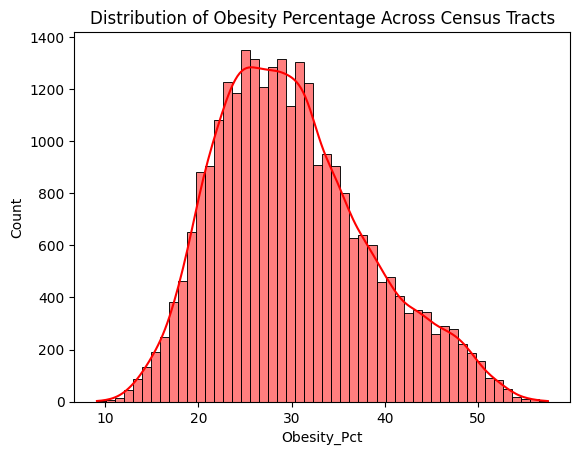

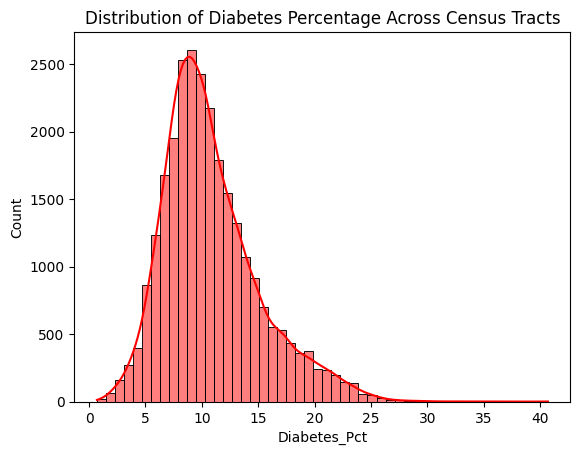

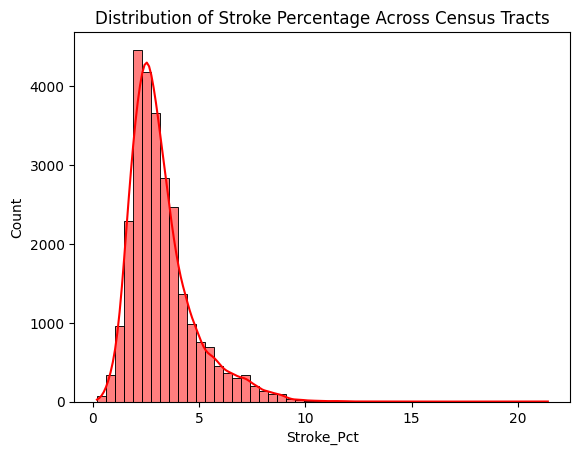

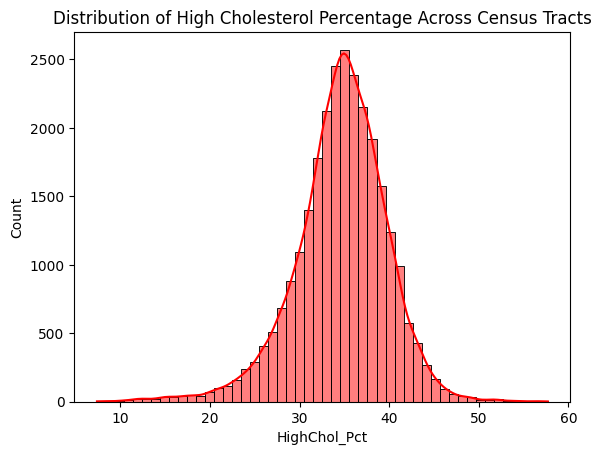

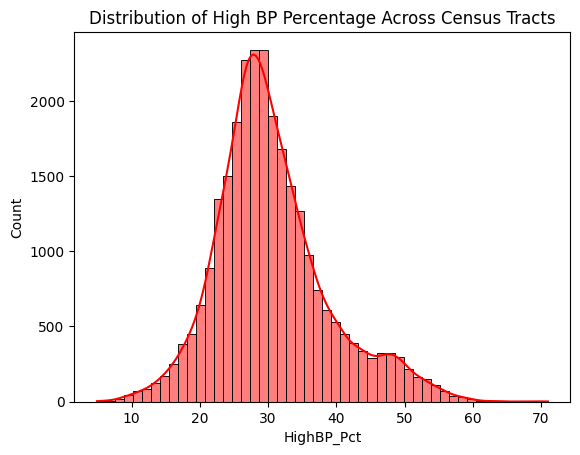

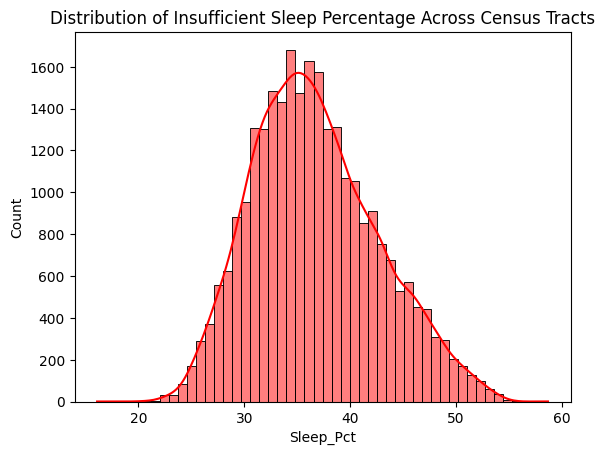

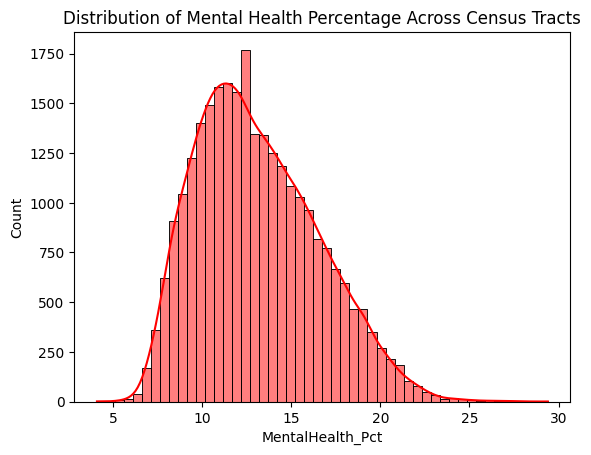

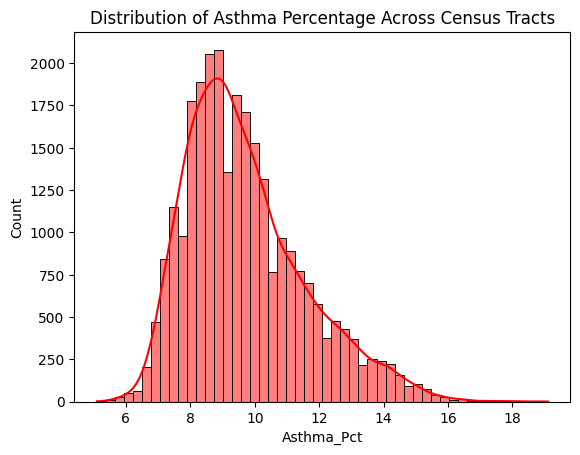

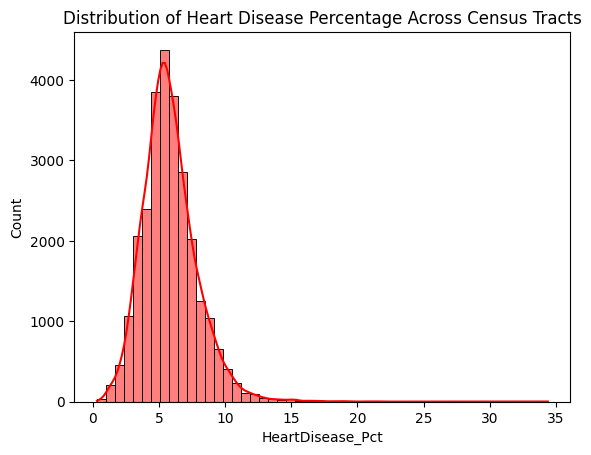

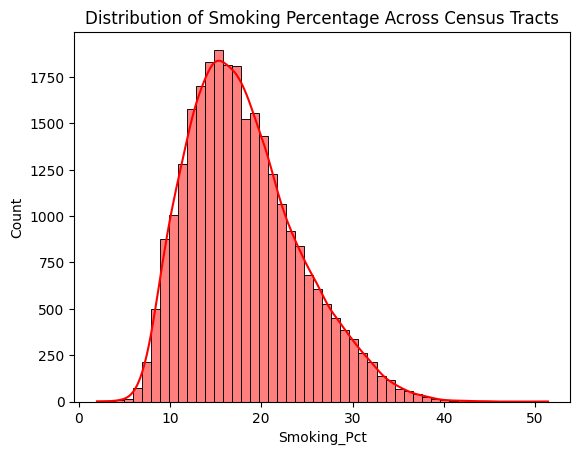

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

#Visualize distributions

#obesity
sns.histplot(data=merged_df, x='Obesity_Pct', bins=50, kde=True, color='red')
plt.title('Distribution of Obesity Percentage Across Census Tracts')
plt.show()

#diabetes
sns.histplot(data=merged_df, x='Diabetes_Pct', bins=50, kde=True, color='red')
plt.title('Distribution of Diabetes Percentage Across Census Tracts')
plt.show()

#stroke
sns.histplot(data=merged_df, x='Stroke_Pct', bins=50, kde=True, color='red')
plt.title('Distribution of Stroke Percentage Across Census Tracts')
plt.show()

#high chol
sns.histplot(data=merged_df, x='HighChol_Pct', bins=50, kde=True, color='red')
plt.title('Distribution of High Cholesterol Percentage Across Census Tracts')
plt.show()

#high BP
sns.histplot(data=merged_df, x='HighBP_Pct', bins=50, kde=True, color='red')
plt.title('Distribution of High BP Percentage Across Census Tracts')
plt.show()

#sleep
sns.histplot(data=merged_df, x='Sleep_Pct', bins=50, kde=True, color='red')
plt.title('Distribution of Insufficient Sleep Percentage Across Census Tracts')
plt.show()

#mental health
sns.histplot(data=merged_df, x='MentalHealth_Pct', bins=50, kde=True, color='red')
plt.title('Distribution of Mental Health Percentage Across Census Tracts')
plt.show()

#asthma
sns.histplot(data=merged_df, x='Asthma_Pct', bins=50, kde=True, color='red')
plt.title('Distribution of Asthma Percentage Across Census Tracts')
plt.show()

#heart disease
sns.histplot(data=merged_df, x='HeartDisease_Pct', bins=50, kde=True, color='red')
plt.title('Distribution of Heart Disease Percentage Across Census Tracts')
plt.show()

#Smoking
sns.histplot(data=merged_df, x='Smoking_Pct', bins=50, kde=True, color='red')
plt.title('Distribution of Smoking Percentage Across Census Tracts')
plt.show()

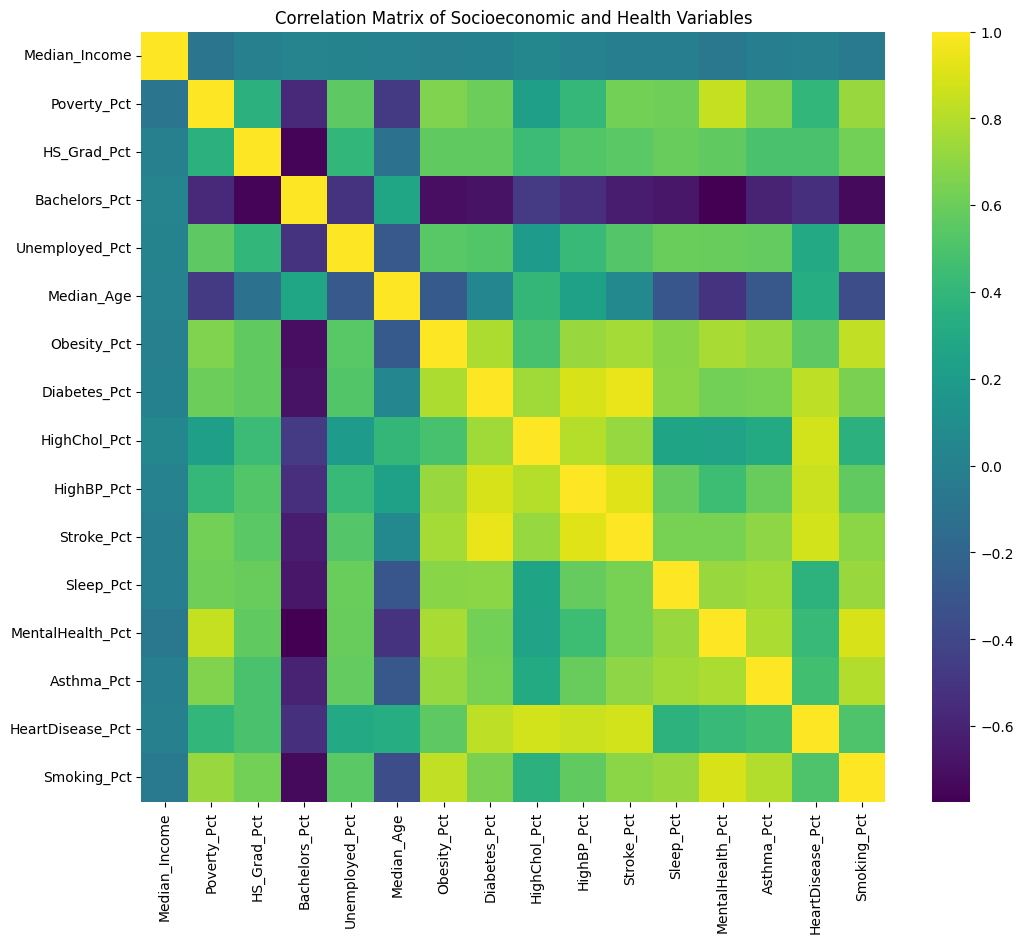

In [43]:
#Bivariate Analysis

#Correlation Matrix

variables_to_compare = [
    #socioeconomic variables first
    'Median_Income',
    'Poverty_Pct',
    'HS_Grad_Pct',
    'Bachelors_Pct',
    'Unemployed_Pct',
    'Median_Age',
    'Obesity_Pct',
    'Diabetes_Pct',
    'HighChol_Pct',
    'HighBP_Pct',
    'Stroke_Pct',
    'Sleep_Pct',
    'MentalHealth_Pct',
    'Asthma_Pct',
    'HeartDisease_Pct',
    'Smoking_Pct'
]

selected_data = merged_df[variables_to_compare]
corr_matrix = selected_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='viridis')
plt.title('Correlation Matrix of Socioeconomic and Health Variables')
plt.show()

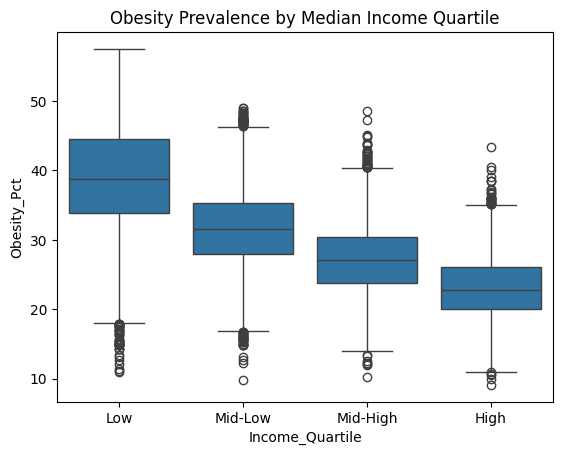

In [44]:
#Some grouped analysis

#Began by grouping median income into different income quartiles

merged_df['Income_Quartile'] = pd.qcut(merged_df['Median_Income'], 4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])
sns.boxplot(data=merged_df, x='Income_Quartile', y='Obesity_Pct')
plt.title('Obesity Prevalence by Median Income Quartile')
plt.show()

In [45]:
#i tried a chloropleth map but im not sure if this will help a lot

# pip install geopandas pygris
# pip install mapclassify


#creating GEOID column that is a combo of STATE FIPS, County FIPS, and Tract FIPS


merged_df['State_FIPS'] = merged_df['State_FIPS'].astype(str).str.zfill(2)
merged_df['County_FIPS'] = merged_df['County_FIPS'].astype(str).str.zfill(3)
merged_df['Tract_FIPS'] = merged_df['Tract_FIPS'].astype(str).str.zfill(6)

merged_df['GEOID'] = merged_df['State_FIPS'] + merged_df['County_FIPS'] + merged_df['Tract_FIPS']

merged_df.head()

,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Tract_FIPS_full,Health_Pop,Obesity_Pct,Obesity_Count,Diabetes_Pct,...,Poverty_Pct,Poverty_Count,HS_Grad_Pct,HS_Grad_Count,Bachelors_Pct,Bachelors_Count,Unemployed_Pct,Unemployed_Count,Income_Quartile,GEOID
0,CA,Los Angeles,644000,6037206032,0644000-06037206032,06037206032,5275,29.5,1556.0,15.5,...,35.834639,1829,23.116438,675,10.582192,309,4.823990,185,Low,06037206032
1,CA,Pasadena,656000,6037462001,0656000-06037462001,06037462001,3974,32.0,1272.0,11.6,...,24.325713,947,19.636213,475,15.171558,367,5.752670,167,Mid-Low,06037462001
2,CA,Fullerton,628000,6059011504,0628000-06059011504,06059011504,5473,18.7,1023.0,4.6,...,36.493289,1740,9.068924,225,35.187424,873,6.832522,379,Low,06059011504
3,TX,Longview,4843888,48183000401,4843888-48183000401,48183000401,3371,33.9,1143.0,9.2,...,14.321767,454,28.173375,637,8.889872,201,4.592980,123,Mid-High,48183000401
4,WI,Madison,5548000,55025002200,5548000-55025002200,55025002200,4254,29.5,1255.0,8.7,...,12.195728,491,18.022054,523,20.468642,594,9.886264,339,Mid-Low,55025002200


Using FIPS code '48' for input 'TX'
HTTP download failed, trying FTP as fallback...


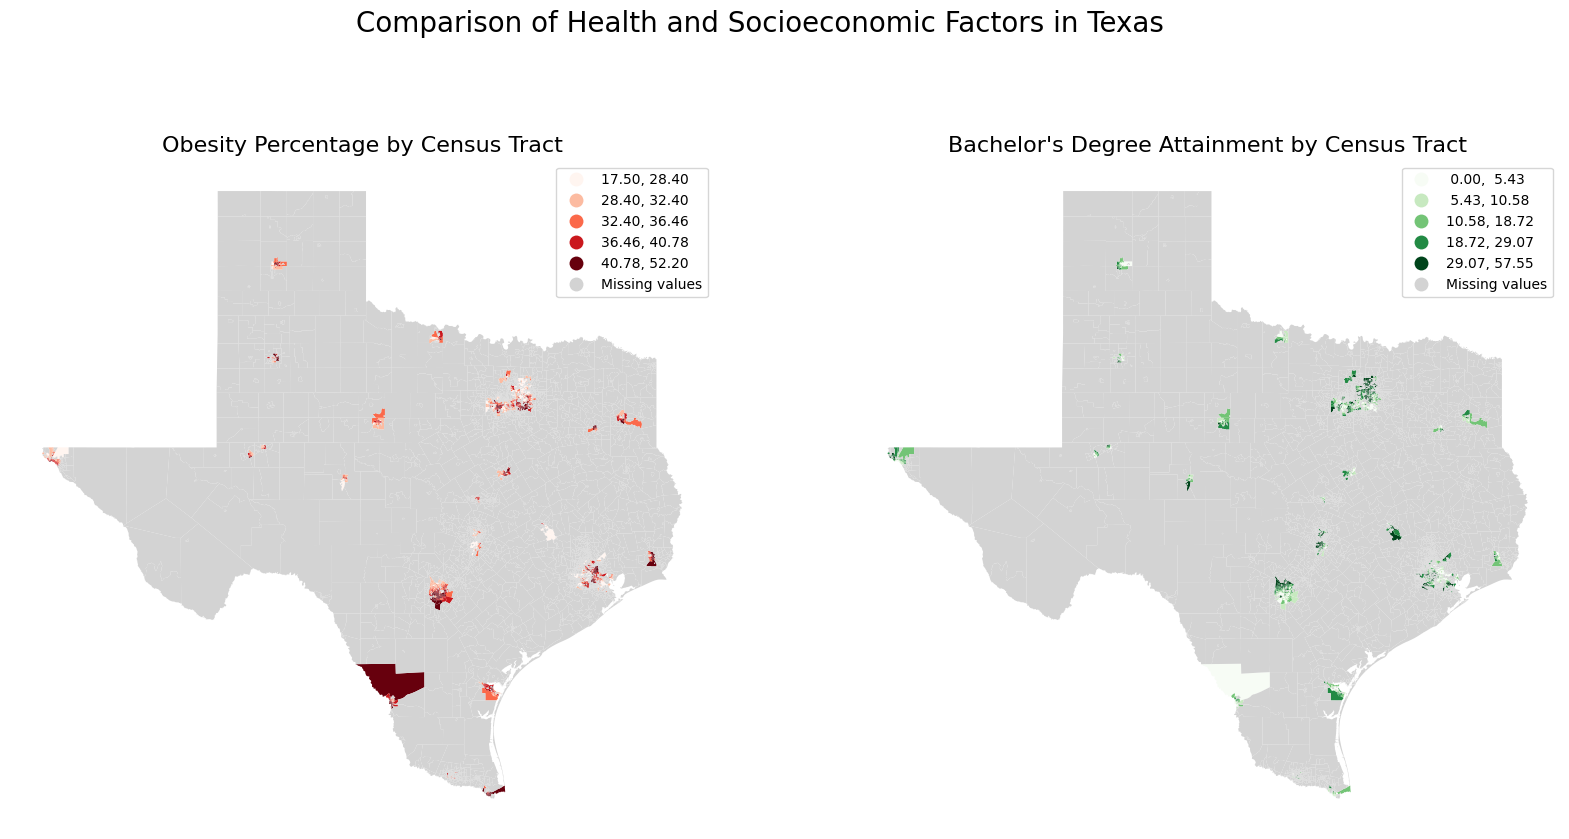

In [48]:
import geopandas as gpd
import matplotlib.pyplot as plt
from pygris import tracts # for census shapes

#can changes by state we are analyzing
geo_tracts = tracts(state='TX', cb=True, year=2021)

#merging with the geographic data
map_df = geo_tracts.merge(merged_df, on='GEOID', how='left')


fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# map 1: obesity_pct
map_df.plot(column='Obesity_Pct',
            ax=axes[0],
            legend=True,
            cmap='Reds', # red for negative health
            scheme='quantiles',
            k=5,
            missing_kwds={
                "color": "lightgrey",
                "label": "Missing values",
            })
axes[0].set_title('Obesity Percentage by Census Tract', fontsize=16)
axes[0].set_axis_off()

# map 2: bachelors
map_df.plot(column='Bachelors_Pct',
            ax=axes[1],
            legend=True,
            cmap='Greens', # green bc positive socioeconomic factor
            scheme='quantiles',
            k=5,
            missing_kwds={
                "color": "lightgrey",
                "label": "Missing values",
            })
axes[1].set_title("Bachelor's Degree Attainment by Census Tract", fontsize=16)
axes[1].set_axis_off()

fig.suptitle('Comparison of Health and Socioeconomic Factors in Texas', fontsize=20)

plt.show()